# Discrete Probabilistic Methods Exercises

21  February 2023

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from env import username, host, password
import env



## Use basic probability to identify anomalous requests. Using the methods covered in this lesson, examine the rest of the features in the api access logs data set.

In [2]:
# function to deal with parsing one entry in our log data


def parse_log_entry(entry):
    
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1].replace(':', ' ', 1)
    output['request_method'] = parts[6]
    output['http_version'] = parts[7][: -1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:1]).replace('"', '')
    
    return pd.Series(output)
    

In [3]:

url = f'mysql+pymysql://{env.username}:{env.password}@{env.host}/logs'
    
df = pd.read_sql('SELECT * FROM api_access', url)

# df = pd.concat([df.entry, df.entry.apply(parse_log_entry)], axis=1)
df = df.entry.apply(parse_log_entry)

In [19]:
df.sample(3)

,ip,timestamp,request_method,http_version,status_code,size,user_agent
10812,97.105.19.58,1,/api/v1/sales?page=53,HTTP/1.1,200,511577,
6666,97.105.19.58,1,/api/v1/sales?page=15,HTTP/1.1,200,501736,
5925,97.105.19.58,1,/api/v1/sales?page=2,HTTP/1.1,200,494819,


In [21]:
# a count of each timestamp

df['timestamp'].value_counts()

1    13974
Name: timestamp, dtype: int64

In [32]:
# count of 'request_method'

df['request_method'].value_counts().head()

/api/v1/sales?page=2    709
/api/v1/items           464
/api/v1/items?page=2    291
/api/v1/items?page=3    219
/api/v1/stores          162
Name: request_method, dtype: int64

In [33]:
# pc count of 'request_method'

df['request_method'].value_counts(normalize = True).head()

/api/v1/sales?page=2    0.050737
/api/v1/items           0.033205
/api/v1/items?page=2    0.020824
/api/v1/items?page=3    0.015672
/api/v1/stores          0.011593
Name: request_method, dtype: float64

In [24]:
# count of each httpversion

df['http_version'].value_counts()

HTTP/1.1    13974
Name: http_version, dtype: int64

In [26]:
# pc of 

df['http_version'].value_counts(normalize = True)

HTTP/1.1    1.0
Name: http_version, dtype: float64

In [23]:
# count of each status code

df['status_code'].value_counts().sum()

13974

In [28]:
# count of each 'size'

df['size'].value_counts().head()

494819    705
3561      548
3659      291
1328      229
1787      219
Name: size, dtype: int64

In [29]:
# pc count of each 'size'

df['size'].value_counts(normalize = True).head()

494819    0.050451
3561      0.039216
3659      0.020824
1328      0.016388
1787      0.015672
Name: size, dtype: float64

In [30]:
# user agent

df['user_agent'].value_counts()

    13974
Name: user_agent, dtype: int64

In [36]:
# function to merge the two 


def value_counts_and_freqs(s : pd.Series, dropna = True) -> pd.DataFrame:
    
    return pd.merge(
            s.value_counts(dropna = False).rename('count'),
            s.value_counts(dropna = False, normalize = True).rename('proba'),
            left_index = True,
            right_index = True)

In [37]:
# creating 'request_method' df

request_method_df = value_counts_and_freqs(df['request_method'])

request_method_df.head()

,count,proba
/api/v1/sales?page=2,709,0.050737
/api/v1/items,464,0.033205
/api/v1/items?page=2,291,0.020824
/api/v1/items?page=3,219,0.015672
/api/v1/stores,162,0.011593


In [45]:
# creating 'size' df

size_df = value_counts_and_freqs(df['size'])

size_df.head()

,count,proba
494819,705,0.050451
3561,548,0.039216
3659,291,0.020824
1328,229,0.016388
1787,219,0.015672


<AxesSubplot:>

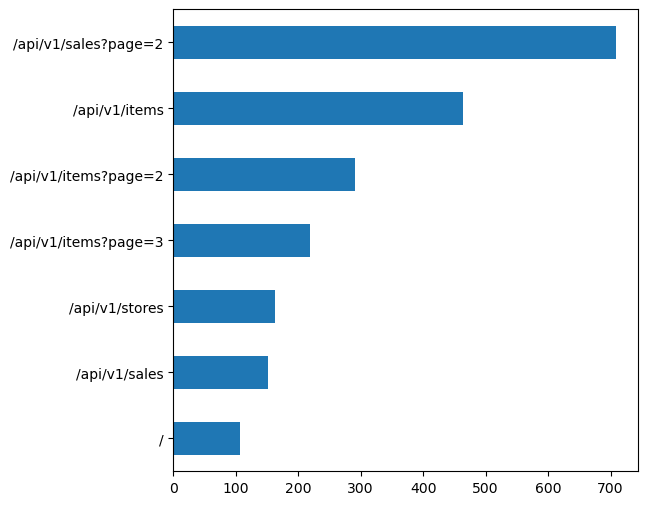

In [54]:
# counting unique entries for request_method

request_method_df['count'].sort_values().tail(7).plot.barh(figsize = (6, 6))

The majority come from the 'page=2' request method, followed by 'v1/items'

<AxesSubplot:>

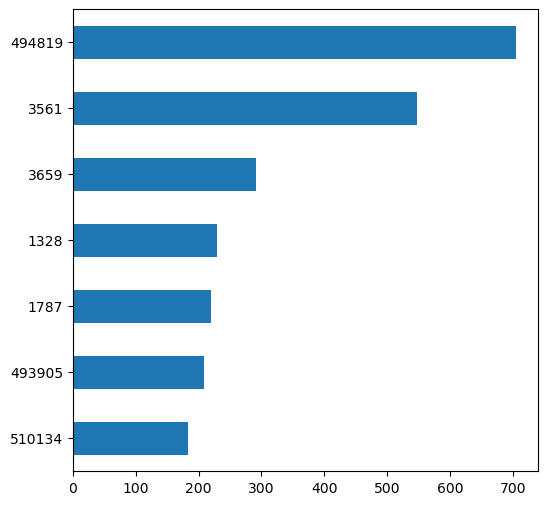

In [55]:
# counting unique entries for size

size_df['count'].sort_values().tail(7).plot.barh(figsize = (6, 6))

The majority have a size of 494819, followed by a size of 3561.

In [62]:
# look at request_method, status and the probability that it will the that status

status_given_req_meth = (df.groupby('request_method')
                        .status_code.value_counts(normalize = True)
                        .rename('proba_status_given_req_meth')
                        .reset_index())

status_given_req_meth.sample(5)

,request_method,status_code,proba_status_given_req_meth
177,/api/v1/sales?page=66,200,1.0
133,/api/v1/sales?page=28,200,1.0
28,/api/v1/sales?page=102,200,1.0
54,/api/v1/sales?page=125,200,1.0
46,/api/v1/sales?page=118,200,1.0


In [70]:
# what about the statuses that are not successful in status_given_req_meth df ?

status_given_req_meth[status_given_req_meth['status_code'] != '200'].sort_values(
                                by = 'proba_status_given_req_meth', ascending = False)

,request_method,status_code,proba_status_given_req_meth
64,/api/v1/sales?page=133,499,0.016667
43,/api/v1/sales?page=115,499,0.016393
196,/api/v1/sales?page=80,499,0.016129
181,/api/v1/sales?page=69,499,0.015625
156,/api/v1/sales?page=47,499,0.014925
135,/api/v1/sales?page=29,499,0.014493
130,/api/v1/sales?page=25,499,0.014085
125,/api/v1/sales?page=21,499,0.013699
194,/api/v1/sales?page=8,499,0.013158
10,/api/v1/items,499,0.008621


Interesting that one of the most frequent 'request_method' entries ('v1/items') is also a 499 code, about 0.4pc of the time. Same for the most frequent 'request_method' of 'page=2' : it's also a 499 status code, about 0.9pc of the time.

("The HTTP 499 status code, also known as a “client closed request,” is a special case of the 502 Bad Gateway Error. It indicates that the client has closed the connection while the server is still processing the request." — Kinsta.com)

In [76]:
# why are these request methods getting 499 codes ?

df[df['request_method'] == '/api/v1/items'].sample()

,ip,timestamp,request_method,http_version,status_code,size,user_agent
3824,97.105.19.58,1,/api/v1/items,HTTP/1.1,200,3561,


In [75]:
# why are these request methods getting 499 codes ?

df[df['request_method'] == '/api/v1/sales?page=2'].sample()

,ip,timestamp,request_method,http_version,status_code,size,user_agent
10300,97.105.19.58,1,/api/v1/sales?page=2,HTTP/1.1,200,494819,


Based on available data, it's unclear why they're getting 499 codes.

In [77]:
# likelyhood that the status of a given request method is less than 100% 

status_given_req_meth[status_given_req_meth['proba_status_given_req_meth'] < 1]

,request_method,status_code,proba_status_given_req_meth
9,/api/v1/items,200,0.991379
10,/api/v1/items,499,0.008621
42,/api/v1/sales?page=115,200,0.983607
43,/api/v1/sales?page=115,499,0.016393
63,/api/v1/sales?page=133,200,0.983333
64,/api/v1/sales?page=133,499,0.016667
121,/api/v1/sales?page=2,200,0.995769
122,/api/v1/sales?page=2,499,0.004231
124,/api/v1/sales?page=21,200,0.986301
125,/api/v1/sales?page=21,499,0.013699


Overall, the request methods are successful the majority of the time (+98pc in all cases).

### Doing the same for 'size'

In [79]:
# look at size, status and the probability that it will the that status

status_given_size = (df.groupby('size')
                        .status_code.value_counts(normalize = True)
                        .rename('proba_status_given_size')
                        .reset_index())

status_given_size.sample(5)

,size,status_code,proba_status_given_size
157,511980,200,1.0
11,278377,200,1.0
181,512764,200,1.0
133,511340,200,1.0
123,511076,200,1.0


In [80]:
# what about the statuses that are not successful in status_given_size df ?

status_given_size[status_given_size['status_code'] != '200'].sort_values(
                                by = 'proba_status_given_size', ascending = False)

,size,status_code,proba_status_given_size
0,0,499,1.0


The only size that got a 499 code had a size of 0.

In [86]:
# why does this size getting 499 codes ?

df[df['size'] == '0'].head()

,ip,timestamp,request_method,http_version,status_code,size,user_agent


Nothing.

In [87]:
# likelyhood that the status of a given request method is less than 100% 

status_given_size[status_given_size['proba_status_given_size'] < 1]

,size,status_code,proba_status_given_size
